In [90]:
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import pandas as pd
from sklearn.linear_model import LogisticRegression

# ======================================================================
# 0. CONFIGURATION & CONSTANTS
# ======================================================================

FILE_PATH = "temp_data.xml"  # XML file must be in current directory
INVALID_VAL = -999.0
GRID_LAT_SIZE = 120
GRID_LON_SIZE = 67
START_LON = 120.00
END_LON = 121.98
START_LAT = 21.88
END_LAT = 25.45
STEP_SIZE = 0.03

# Piecewise Partition Splits (you can tune these)
LON_SPLIT_1 = 121.50
LON_SPLIT_2 = 120.77
LAT_SPLIT = 24.0

# Centering Constants for Numerical Stability
LON_CENTER = 121.0
LAT_CENTER = 23.5

# ======================================================================
# HELPER FUNCTIONS
# ======================================================================

def get_region_mask(X, lon_split_1, lon_split_2, lat_split):
    """Generates boolean masks for the four regions based on raw coordinates."""
    lon, lat = X[:, 0], X[:, 1]
    mask_r1 = (lon < lon_split_1) & (lat > lat_split)
    mask_r2 = (lon >= lon_split_1) & (lat > lat_split)
    mask_r3 = (lon < lon_split_2) & (lat <= lat_split)
    mask_r4 = (lon >= lon_split_2) & (lat <= lat_split)
    return {1: mask_r1, 2: mask_r2, 3: mask_r3, 4: mask_r4}


# 1. Quadratic features for REGRESSION (centered)
# Feature order returned: [1, x', y', (x')^2, (y')^2, x'y']
def get_quad_features(X):
    lon_centered = X[:, 0] - LON_CENTER
    lat_centered = X[:, 1] - LAT_CENTER
    return np.column_stack([
        np.ones_like(lon_centered),   # intercept term (f)
        lon_centered,                 # linear lon (d)
        lat_centered,                 # linear lat (e)
        lon_centered**2,              # lon^2 (a)
        lat_centered**2,              # lat^2 (b)
        lon_centered * lat_centered   # lon*lat (c)
    ])


# 2. Quadratic features for CLASSIFICATION (centered)
# Feature order returned: [(x')^2, (y')^2, x'y', x', y']
def get_quad_features_clf(X):
    lon_centered = X[:, 0] - LON_CENTER
    lat_centered = X[:, 1] - LAT_CENTER
    return np.column_stack([
        lon_centered**2,
        lat_centered**2,
        lon_centered * lat_centered,
        lon_centered,
        lat_centered
    ])


# 3. Prediction helper for piecewise classification (returns -1/0 or 1)
def predict_h_quadratic_neg1_1(X_test, Z_test, h_models, lon_split_1, lon_split_2, lat_split):
    y_pred = np.zeros(len(X_test), dtype=float)
    for i in range(len(X_test)):
        lon_val, lat_val = X_test[i]
        if lat_val > lat_split:
            k = 1 if lon_val < lon_split_1 else 2
        else:
            k = 3 if lon_val < lon_split_2 else 4

        model = h_models.get(k)
        # Use centered classification features taken from Z_test (precomputed by caller)
        Z_i = Z_test[i].reshape(1, -1)

        if isinstance(model, dict):
            # If region had only one class during training, model stores dominant_class
            y_pred[i] = model['dominant_class']
        elif model is not None:
            # LinearSVC.predict returns labels (-1 or 1) because we trained with those labels
            y_pred[i] = model.predict(Z_i)[0]
        else:
            # fallback -> sea
            y_pred[i] = -1.0

    return y_pred

# 4 Cubic Feature Order: [1, x', y', (x')^2, x'y', (y')^2, (x')^3, (x')^2y', x'(y')^2, (y')^3] (10 features)
def get_cubic_features(X):
    """
    Generates 10-feature matrix for cubic regression using centered coordinates.
    The order is (1, x', y', x'^2, x'y', y'^2, x'^3, x'^2y', x'y'^2, y'^3)
    """
    lon_centered = X[:, 0] - LON_CENTER
    lat_centered = X[:, 1] - LAT_CENTER

    X_centered = pd.DataFrame({'x': lon_centered, 'y': lat_centered})

    # Create the polynomial terms up to degree 3
    X_poly = pd.DataFrame({
        '1': np.ones_like(lon_centered),
        'x': X_centered['x'],
        'y': X_centered['y'],
        'x2': X_centered['x']**2,
        'xy': X_centered['x'] * X_centered['y'],
        'y2': X_centered['y']**2,
        'x3': X_centered['x']**3,
        'x2y': X_centered['x']**2 * X_centered['y'],
        'xy2': X_centered['x'] * X_centered['y']**2,
        'y3': X_centered['y']**3
    })
    return X_poly.values

In [91]:
# ======================================================================
# 1. DATA LOADING AND COORDINATE GENERATION
# ======================================================================

print("--- 1. DATA LOADING AND COORDINATE GENERATION ---")
try:
    tree = ET.parse(FILE_PATH)
    root = tree.getroot()

    # Locate the <Content> element robustly (namespace-agnostic)
    content_element = None
    for elem in root.iter():
        if elem.tag.lower().endswith('content'):
            content_element = elem
            break

    if content_element is None or content_element.text is None:
        raise ValueError("Could not find Content element or it is empty in the XML file.")

    content_str = content_element.text

    # Use regex to robustly extract numbers (handles scientific notation)
    number_strings = re.findall(r'[-+]?\d*\.?\d+(?:[Ee][-+]?\d+)?', content_str)
    values = np.array([float(x) for x in number_strings], dtype=np.float64)

    expected_count = GRID_LAT_SIZE * GRID_LON_SIZE
    if values.size != expected_count:
        raise ValueError(f"Parsed {values.size} numeric values but expected {expected_count} "
                         f"({GRID_LAT_SIZE}x{GRID_LON_SIZE}). Check XML content format.")

    # Reshape into lat rows x lon columns (120 x 67)
    grid = values.reshape((GRID_LAT_SIZE, GRID_LON_SIZE))

    print(f"Data loaded. Grid shape: {grid.shape}")

    # Generate coordinates
    lon_steps = np.arange(GRID_LON_SIZE)
    lat_steps = np.arange(GRID_LAT_SIZE)
    LON_COORDS = START_LON + lon_steps * STEP_SIZE
    LAT_COORDS = START_LAT + lat_steps * STEP_SIZE

    LON_GRID, LAT_GRID = np.meshgrid(LON_COORDS, LAT_COORDS)

except FileNotFoundError:
    print(f"FATAL ERROR: XML file not found at {FILE_PATH}.")
    raise
except Exception as e:
    print(f"FATAL ERROR while loading/parsing XML: {e}")
    raise

--- 1. DATA LOADING AND COORDINATE GENERATION ---
Data loaded. Grid shape: (120, 67)


In [92]:
# ======================================================================
# 2A. CREATE SUPERVISED LEARNING DATASETS
# ======================================================================

print("\n--- 2. CREATING SUPERVISED DATASETS ---")
lon_flat, lat_flat = LON_GRID.flatten(), LAT_GRID.flatten()
temp_flat = grid.flatten()

# (a) Classification Dataset (Full Grid)
# Label Rule: Valid (Land) -> 1, Invalid (Sea/Void) -> -1
labels_clf = np.where(temp_flat != INVALID_VAL, 1, -1)
X_clf = np.stack((lon_flat, lat_flat), axis=1)
y_clf = labels_clf
pseudo_labels_clf = np.where(temp_flat != INVALID_VAL, 1, 0)
pseudo_labels_clf = pseudo_labels_clf.reshape(120, 67)

# (b) Regression Dataset (Valid Points Only)
valid_indices = (temp_flat != INVALID_VAL)
X_reg = np.stack((lon_flat[valid_indices], lat_flat[valid_indices]), axis=1)
y_reg = temp_flat[valid_indices]

print(f"Total grid points: {len(X_clf)}, valid points for regression: {len(X_reg)}")
print('--- Sample output for the conversion ---')


--- 2. CREATING SUPERVISED DATASETS ---
Total grid points: 8040, valid points for regression: 3495
--- Sample output for the conversion ---


In [93]:
# ======================================================================
# 2B. GENERATING PANDAS DATAFRAMES (FOR GRADING/FORMATTING)
# ======================================================================

print("\n--- 2B. Generating Pandas DataFrames (Label 0/1) ---")

# --- (a) Classification Dataset ---
# Format: (Longitude, Latitude, Label)
# Label: 0 if -999.0 (Invalid/Sea), 1 if valid (Land)

# The original temp_flat (all points) is used here.
labels_clf_0_1 = np.where(temp_flat != INVALID_VAL, 1, 0)

df_classification = pd.DataFrame({
    'Longitude': lon_flat,
    'Latitude': lat_flat,
    'Label': labels_clf_0_1
})

print("\nClassification Dataset (Head):")
print(df_classification.head())
print(f"Classification Dataset Shape: {df_classification.shape}")


# --- (b) Regression Dataset ---
# Format: (Longitude, Latitude, Value)
# Only valid points are kept.

# X_reg and y_reg (from original Section 2) already contain only valid points.

df_regression = pd.DataFrame({
    'Longitude': X_reg[:, 0],
    'Latitude': X_reg[:, 1],
    'Value': y_reg
})

print("\nRegression Dataset (Head):")
print(df_regression.head())
print(f"Regression Dataset Shape: {df_regression.shape}")


--- 2B. Generating Pandas DataFrames (Label 0/1) ---

Classification Dataset (Head):
   Longitude  Latitude  Label
0     120.00     21.88      0
1     120.03     21.88      0
2     120.06     21.88      0
3     120.09     21.88      0
4     120.12     21.88      0
Classification Dataset Shape: (8040, 3)

Regression Dataset (Head):
   Longitude  Latitude  Value
0     120.84     21.94   28.1
1     120.72     21.97   28.6
2     120.75     21.97   28.6
3     120.78     21.97   27.8
4     120.81     21.97   26.5
Regression Dataset Shape: (3495, 3)


In [94]:
# ======================================================================
# 3. DATA SPLITTING (TRAIN/TEST)
# ======================================================================

# Classification: stratify on labels (works with -1/1)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Regression: random split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [95]:
# ======================================================================
# 4. PIECEWISE QUADRATIC CLASSIFICATION (h_k) - TRAIN
# ======================================================================

Z_clf_train = get_quad_features_clf(X_clf_train)
Z_clf_test = get_quad_features_clf(X_clf_test)

h_models = {}
clf_params = {}

print("\n--- 4. Training Piecewise Quadratic SVM (LinearSVC) Models ---")
region_conditions_clf = get_region_mask(X_clf_train, LON_SPLIT_1, LON_SPLIT_2, LAT_SPLIT)

for k, mask in region_conditions_clf.items():
    Z_k_train = Z_clf_train[mask]
    y_k_train = y_clf_train[mask]

    if Z_k_train.shape[0] == 0:
        # no points in region
        h_models[k] = {'dominant_class': -1}
        print(f"Region {k}: no training points -> default -1")
        continue

    # If only one class present, store dominant_class to avoid training a degenerate classifier
    if len(np.unique(y_k_train)) < 2:
        dom = 1 if np.mean(y_k_train) > 0 else -1
        h_models[k] = {'dominant_class': dom}
        print(f"Region {k}: single-class in training -> dominant_class={dom}")
        continue

    # Train LinearSVC on centered quadratic features
    model_k = LinearSVC(C=1.0, random_state=42, dual=False, max_iter=5000)
    try:
        model_k.fit(Z_k_train, y_k_train)
        h_models[k] = model_k
        coeffs = model_k.coef_.ravel()
        intercept = float(model_k.intercept_[0])
        clf_params[k] = {
            'coef_sq_lon': float(coeffs[0]),
            'coef_sq_lat': float(coeffs[1]),
            'coef_lon_lat': float(coeffs[2]),
            'coef_lon': float(coeffs[3]),
            'coef_lat': float(coeffs[4]),
            'intercept': intercept
        }
        print(f"Region {k}: trained LinearSVC with {Z_k_train.shape[0]} samples.")
    except Exception as e:
        print(f"Region {k}: training failed ({e}). Using dominant class fallback.")
        h_models[k] = {'dominant_class': 1 if np.mean(y_k_train) > 0 else -1}

# Classification evaluation
y_clf_test_pred = predict_h_quadratic_neg1_1(X_clf_test, Z_clf_test, h_models, LON_SPLIT_1, LON_SPLIT_2, LAT_SPLIT)
y_true_binary = np.where(y_clf_test == 1, 1, 0)
y_pred_binary = np.where(y_clf_test_pred == 1, 1, 0)
clf_accuracy = accuracy_score(y_true_binary, y_pred_binary)

print("\n--- Classification Test Results (h) ---")
print(f"Overall Test Accuracy: {clf_accuracy:.4f}")


--- 4. Training Piecewise Quadratic SVM (LinearSVC) Models ---
Region 1: trained LinearSVC with 1949 samples.
Region 2: trained LinearSVC with 663 samples.
Region 3: trained LinearSVC with 1479 samples.
Region 4: trained LinearSVC with 2341 samples.

--- Classification Test Results (h) ---
Overall Test Accuracy: 0.9714


In [96]:
h_lr_models = {}
print("\n--- 4B. Training Piecewise Quadratic Logistic Regression Models (h_k^LR) ---")
region_conditions_clf = get_region_mask(X_clf_train, LON_SPLIT_1, LON_SPLIT_2, LAT_SPLIT)

for k, mask in region_conditions_clf.items():
    Z_k_train = Z_clf_train[mask]
    y_k_train = y_clf_train[mask]

    # Logistic Regression requires positive class to be 1, so we convert -1 to 0
    # y_k_train_lr = np.where(y_k_train == 1, 1, 0)
    # However, LogisticRegression handles binary classification, so we'll map the labels correctly if needed.
    # To keep the models consistent, we'll map to {0, 1} for training, and convert back.
    # Land (1) -> 1, Sea (-1) -> 0
    y_k_train_lr = (y_k_train + 1) / 2
    
    # Skip training if no points or only one class
    if Z_k_train.shape[0] == 0:
        h_lr_models[k] = {'dominant_class': -1}
        print(f"Region {k}: no training points -> default -1")
        continue

    if len(np.unique(y_k_train_lr)) < 2:
        dom = 1 if np.mean(y_k_train) > 0 else -1
        h_lr_models[k] = {'dominant_class': dom}
        print(f"Region {k}: single-class in training -> dominant_class={dom}")
        continue

    # Train Logistic Regression
    # C=1.0 is a common default for regularization strength. max_iter increased for convergence.
    model_k = LogisticRegression(C=1.0, random_state=42, solver='liblinear', max_iter=5000)
    
    try:
        model_k.fit(Z_k_train, y_k_train_lr)
        h_lr_models[k] = model_k
        print(f"Region {k}: trained Logistic Regression with {Z_k_train.shape[0]} samples.")
    except Exception as e:
        print(f"Region {k}: training failed ({e}). Using dominant class fallback.")
        h_lr_models[k] = {'dominant_class': 1 if np.mean(y_k_train) > 0 else -1}

# --- LOGISTIC REGRESSION PREDICTION FUNCTION (similar to predict_h_quadratic_neg1_1) ---

def predict_h_lr_neg1_1(X_test, Z_test, h_lr_models, lon_split_1, lon_split_2, lat_split):
    """Predicts classification labels (-1 or 1) using the piecewise Logistic Regression."""
    y_pred = np.zeros(len(X_test), dtype=float)
    
    for i in range(len(X_test)):
        lon_val, lat_val = X_test[i]
        
        # Determine Region
        if lat_val > lat_split: k = 1 if lon_val < lon_split_1 else 2
        else: k = 3 if lon_val < lon_split_2 else 4
        
        model = h_lr_models.get(k)
        Z_i = Z_test[i].reshape(1, -1)

        if isinstance(model, dict): 
            y_pred[i] = model['dominant_class']
        elif model is not None:
            # Predict returns 0 or 1. We convert 0 -> -1 and 1 -> 1
            y_pred_0_1 = model.predict(Z_i)[0]
            y_pred[i] = y_pred_0_1 * 2 - 1 # Simple conversion: 0 -> -1, 1 -> 1
        else: 
            y_pred[i] = -1 # Default to Sea (-1)
             
    return y_pred

# --- LOGISTIC REGRESSION EVALUATION ---
y_clf_test_pred_lr = predict_h_lr_neg1_1(X_clf_test, Z_clf_test, h_lr_models, LON_SPLIT_1, LON_SPLIT_2, LAT_SPLIT)

# Convert -1/1 labels to 0/1 for standard metric calculation
# y_clf_test comes from the original dataset (y_clf_test is -1/1)
y_true_binary = np.where(y_clf_test == 1, 1, 0)
y_pred_lr_binary = np.where(y_clf_test_pred_lr == 1, 1, 0)

clf_lr_accuracy = accuracy_score(y_true_binary, y_pred_lr_binary)

print("\n--- Classification Test Results (h^LR vs. h^SVC) ---")
print(f"1. Piecewise Logistic Regression (h^LR) Accuracy: {clf_lr_accuracy:.4f}")
# Assuming 'clf_accuracy' from Section 4 (LinearSVC) is still in memory
# If not, you need to ensure Section 4 runs before this.
print(f"2. Piecewise LinearSVC (h^SVC) Accuracy: {clf_accuracy:.4f}")


--- 4B. Training Piecewise Quadratic Logistic Regression Models (h_k^LR) ---
Region 1: trained Logistic Regression with 1949 samples.
Region 2: trained Logistic Regression with 663 samples.
Region 3: trained Logistic Regression with 1479 samples.
Region 4: trained Logistic Regression with 2341 samples.

--- Classification Test Results (h^LR vs. h^SVC) ---
1. Piecewise Logistic Regression (h^LR) Accuracy: 0.9596
2. Piecewise LinearSVC (h^SVC) Accuracy: 0.9714


In [97]:
# ======================================================================
# 5A. PIECEWISE QUADRATIC REGRESSION (g_k) - TRAIN
# ======================================================================

Z_reg_train = get_quad_features(X_reg_train)
Z_reg_test = get_quad_features(X_reg_test)

g_models = {}

print("\n--- 5. Training Piecewise Quadratic Regression Models (g_k) ---")
region_conditions_reg = get_region_mask(X_reg_train, LON_SPLIT_1, LON_SPLIT_2, LAT_SPLIT)

for k, mask in region_conditions_reg.items():
    Z_k = Z_reg_train[mask]
    y_k = y_reg_train[mask]

    if Z_k.shape[0] < 6:
        print(f"Region {k}: not enough points ({Z_k.shape[0]}) for stable regression => skipped")
        continue

    model_k = LinearRegression(fit_intercept=False)
    model_k.fit(Z_k, y_k)
    g_models[k] = model_k

    y_pred_k = model_k.predict(Z_k)
    mse_k = mean_squared_error(y_k, y_pred_k)
    print(f"Region {k} trained with {len(y_k)} points. Training MSE: {mse_k:.4f}")

# Regression evaluation on test set (use region assignment)
y_reg_test_pred_g = np.full_like(y_reg_test, np.nan, dtype=float)

for i in range(len(X_reg_test)):
    lon_val, lat_val = X_reg_test[i]
    z_i = Z_reg_test[i].reshape(1, -1)

    if lat_val > LAT_SPLIT:
        k = 1 if lon_val < LON_SPLIT_1 else 2
    else:
        k = 3 if lon_val < LON_SPLIT_2 else 4

    model = g_models.get(k)
    if model is not None:
        y_reg_test_pred_g[i] = model.predict(z_i)[0]
    else:
        y_reg_test_pred_g[i] = np.nan

valid_predictions_mask = ~np.isnan(y_reg_test_pred_g)
if valid_predictions_mask.sum() > 0:
    final_test_mse = mean_squared_error(y_reg_test[valid_predictions_mask], y_reg_test_pred_g[valid_predictions_mask])
    final_test_rmse = np.sqrt(final_test_mse)
    print(f"\nOverall Test RMSE for g (over regions with models): {final_test_rmse:.4f} °C")
else:
    print("\nNo valid region predictions available for regression test set.")

# Print regression coefficients with clear mapping
print("\n--- Regression Functions (g_k) - Centered feature mapping ---")
print("Feature vector order used: [1, x', y', (x')^2, (y')^2, x'y']")
print(f"Center used: (lon, lat) = ({LON_CENTER}, {LAT_CENTER})")
for k, model in g_models.items():
    coeffs = model.coef_.ravel()
    # Map coefficients to formula g(x',y') = a(x')^2 + b(y')^2 + c(x'y') + d(x') + e(y') + f
    f_const = coeffs[0]
    d_lin  = coeffs[1]
    e_lin  = coeffs[2]
    a_quad = coeffs[3]
    b_quad = coeffs[4]
    c_mix  = coeffs[5]

    print(f"Region {k} (g{k}): a: {a_quad: .6f}, b: {b_quad: .6f}, c: {c_mix: .6f}, d: {d_lin: .6f}, e: {e_lin: .6f}, f: {f_const: .6f}")


--- 5. Training Piecewise Quadratic Regression Models (g_k) ---
Region 1 trained with 776 points. Training MSE: 11.9477
Region 2 trained with 344 points. Training MSE: 8.8725
Region 3 trained with 804 points. Training MSE: 3.5181
Region 4 trained with 872 points. Training MSE: 28.1626

Overall Test RMSE for g (over regions with models): 4.2064 °C

--- Regression Functions (g_k) - Centered feature mapping ---
Feature vector order used: [1, x', y', (x')^2, (y')^2, x'y']
Center used: (lon, lat) = (121.0, 23.5)
Region 1 (g1): a:  4.174530, b:  16.917200, c: -0.125119, d: -13.582845, e: -23.365285, f:  28.394448
Region 2 (g2): a:  0.765705, b:  5.503241, c: -35.030857, d:  54.523550, e:  13.394503, f: -8.090904
Region 3 (g3): a: -30.153946, b:  7.959234, c:  3.148909, d: -43.687006, e:  6.113435, f:  9.361388
Region 4 (g4): a:  70.471215, b:  13.207995, c: -37.457183, d: -5.715513, e:  1.690680, f:  11.743298


In [98]:
# ======================================================================
# 5B. LOGISTIC REGRESSION COEFFICIENT OUTPUT
# ======================================================================

print("\n--- Logistic Regression Boundary Functions (h_k^LR) - Centered feature mapping ---")
print("Function: w1(x')² + w2(y')² + w3(x'y') + w4(x') + w5(y') + w6 = 0")
print("Feature vector order used: [x'², y'², x'y', x', y']")
print(f"Center used: (lon, lat) = ({LON_CENTER}, {LAT_CENTER})")

lr_boundary_coeffs = {}

for k, model in h_lr_models.items():
    if isinstance(model, LogisticRegression):
        coeffs = model.coef_.ravel()
        intercept = model.intercept_[0]
        
        # Feature vector order for h_k is: [x'², y'², x'y', x', y']
        w1_quad_lon2 = coeffs[0]
        w2_quad_lat2 = coeffs[1]
        w3_mix_lonlat = coeffs[2]
        w4_lin_lon = coeffs[3]
        w5_lin_lat = coeffs[4]
        w6_intercept = intercept

        # Print the coefficients in a clear format
        print(f"Region {k} (h{k}^LR): w1: {w1_quad_lon2: .6f}, w2: {w2_quad_lat2: .6f}, w3: {w3_mix_lonlat: .6f}, w4: {w4_lin_lon: .6f}, w5: {w5_lin_lat: .6f}, w6: {w6_intercept: .6f}")
    
    elif isinstance(model, dict) and 'dominant_class' in model:
        print(f"Region {k} (h{k}^LR): Skipped (Single-class region, dominant_class={model['dominant_class']})")
    else:
        print(f"Region {k} (h{k}^LR): Model not trained.")


--- Logistic Regression Boundary Functions (h_k^LR) - Centered feature mapping ---
Function: w1(x')² + w2(y')² + w3(x'y') + w4(x') + w5(y') + w6 = 0
Feature vector order used: [x'², y'², x'y', x', y']
Center used: (lon, lat) = (121.0, 23.5)
Region 1 (h1^LR): w1: -4.571562, w2: -5.074434, w3:  4.407662, w4:  5.383962, w5:  2.348556, w6:  6.440005
Region 2 (h2^LR): w1: -5.792482, w2: -3.296798, w3:  1.783759, w4: -2.931580, w5:  5.978728, w6:  2.070767
Region 3 (h3^LR): w1: -6.864623, w2: -5.372862, w3: -1.122463, w4:  2.736763, w5: -2.615785, w6:  7.652948
Region 4 (h4^LR): w1: -5.173973, w2: -1.820739, w3:  3.821417, w4: -8.270687, w5:  3.033633, w6:  5.298090


In [99]:
# ======================================================================
# 6. FINAL COMBINED HYPOTHESIS GRID (h = g * mask)
# ======================================================================

print("\n--- 6. FINAL COMBINED HYPOTHESIS GRID (h = g * mask) ---")

Z_clf_reg = get_quad_features(X_clf)       # regression features for full grid (centered)
Z_clf_clf = get_quad_features_clf(X_clf)   # classification features for full grid (centered)

FULL_GRID_SIZE = len(X_clf)
g_pred_full = np.zeros(FULL_GRID_SIZE, dtype=float)
h_mask_full_neg1_1 = np.zeros(FULL_GRID_SIZE, dtype=float)

for i in range(FULL_GRID_SIZE):
    lon_val, lat_val = X_clf[i]
    if lat_val > LAT_SPLIT:
        k = 1 if lon_val < LON_SPLIT_1 else 2
    else:
        k = 3 if lon_val < LON_SPLIT_2 else 4

    # g_k prediction
    model_g = g_models.get(k)
    z_i_reg = Z_clf_reg[i].reshape(1, -1)
    if model_g is not None:
        g_pred_full[i] = model_g.predict(z_i_reg)[0]
    else:
        g_pred_full[i] = 0.0

    # h_k prediction
    model_h = h_models.get(k)
    z_i_clf = Z_clf_clf[i].reshape(1, -1)
    if isinstance(model_h, dict):
        h_mask_full_neg1_1[i] = model_h['dominant_class']
    elif model_h is not None:
        h_mask_full_neg1_1[i] = model_h.predict(z_i_clf)[0]
    else:
        h_mask_full_neg1_1[i] = -1.0

# convert to 0/1 mask
final_mask_0_1 = np.where(h_mask_full_neg1_1 == 1, 1, 0)
h_pred_flat = g_pred_full * final_mask_0_1
predicted_grid = h_pred_flat.reshape(GRID_LAT_SIZE, GRID_LON_SIZE)

print(f"Final predicted grid shape: {predicted_grid.shape}")


--- 6. FINAL COMBINED HYPOTHESIS GRID (h = g * mask) ---
Final predicted grid shape: (120, 67)


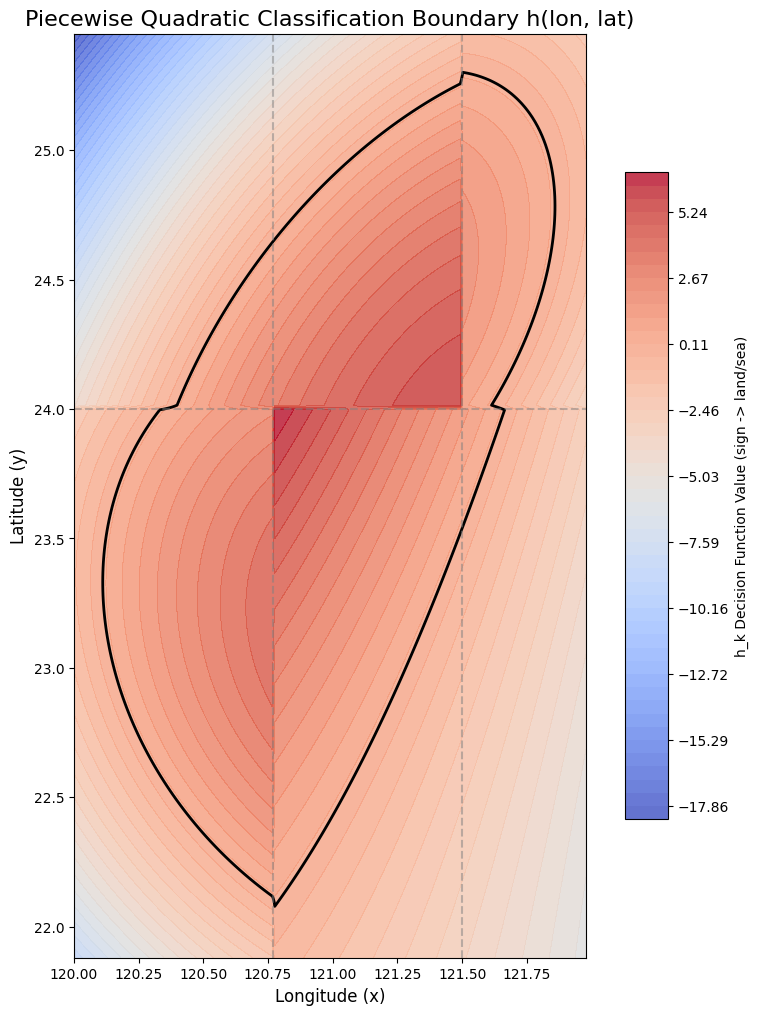

In [ ]:
# ======================================================================
# 7A. PLOTTING
# ======================================================================

# --- 7B. 2D Contour Plot of the Classification Boundary (h_k) ---
lon_space_h = np.linspace(START_LON, END_LON, 200)
lat_space_h = np.linspace(START_LAT, END_LAT, 200)
LON_PLOT_H, LAT_PLOT_H = np.meshgrid(lon_space_h, lat_space_h)

X_plot_h = np.column_stack([LON_PLOT_H.ravel(), LAT_PLOT_H.ravel()])
Z_plot_clf_h = get_quad_features_clf(X_plot_h)

H_PRED_PLOT = np.zeros(X_plot_h.shape[0])
for i in range(len(X_plot_h)):
    lon_val, lat_val = X_plot_h[i]
    if lat_val > LAT_SPLIT:
        k = 1 if lon_val < LON_SPLIT_1 else 2
    else:
        k = 3 if lon_val < LON_SPLIT_2 else 4

    model_h = h_models.get(k)
    Z_i = Z_plot_clf_h[i].reshape(1, -1)

    if isinstance(model_h, dict):
        H_PRED_PLOT[i] = 10.0 if model_h['dominant_class'] == 1 else -10.0
    elif model_h is not None:
        # LinearSVC supports decision_function
        try:
            H_PRED_PLOT[i] = model_h.decision_function(Z_i)[0]
        except Exception:
            H_PRED_PLOT[i] = model_h.predict(Z_i)[0]
    else:
        H_PRED_PLOT[i] = -10.0

H_PLOT = H_PRED_PLOT.reshape(LON_PLOT_H.shape)

fig, ax = plt.subplots(figsize=(10, 12))
contour_fill = ax.contourf(LON_PLOT_H, LAT_PLOT_H, H_PLOT,
                           levels=np.linspace(np.nanmin(H_PLOT), np.nanmax(H_PLOT), 50),
                           cmap='coolwarm', alpha=0.8)

contour_line = ax.contour(LON_PLOT_H, LAT_PLOT_H, H_PLOT,
                          levels=[0], colors='k', linewidths=2, linestyles='solid')

ax.set_title('Piecewise Quadratic Classification Boundary h(lon, lat)', fontsize=16)
ax.set_xlabel('Longitude (x)', fontsize=12)
ax.set_ylabel('Latitude (y)', fontsize=12)
ax.set_xlim(START_LON, END_LON)
ax.set_ylim(START_LAT, END_LAT)
ax.set_aspect('equal')

# Add region partition lines for reference
ax.axvline(LON_SPLIT_1, color='gray', linestyle='--', alpha=0.5, label='Partition Line 1')
ax.axvline(LON_SPLIT_2, color='gray', linestyle='--', alpha=0.5, label='Partition Line 2')
ax.axhline(LAT_SPLIT, color='gray', linestyle='--', alpha=0.5, label='Lat Split')

plt.colorbar(contour_fill, ax=ax, shrink=0.7, aspect=15,
             label='h_k Decision Function Value (sign -> land/sea)')
plt.show()


--- Plotting Actual Coastline ---


C:\Users\benny\AppData\Local\Temp\ipykernel_18352\3914010494.py:53: UserWarning: The following kwargs were not used by contour: 'label'
  contour_line_predicted = ax.contour(LON_PLOT_H, LAT_PLOT_H, H_PLOT,
C:\Users\benny\AppData\Local\Temp\ipykernel_18352\3914010494.py:85: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_line_predicted.collections[0],
C:\Users\benny\AppData\Local\Temp\ipykernel_18352\3914010494.py:84: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles=[


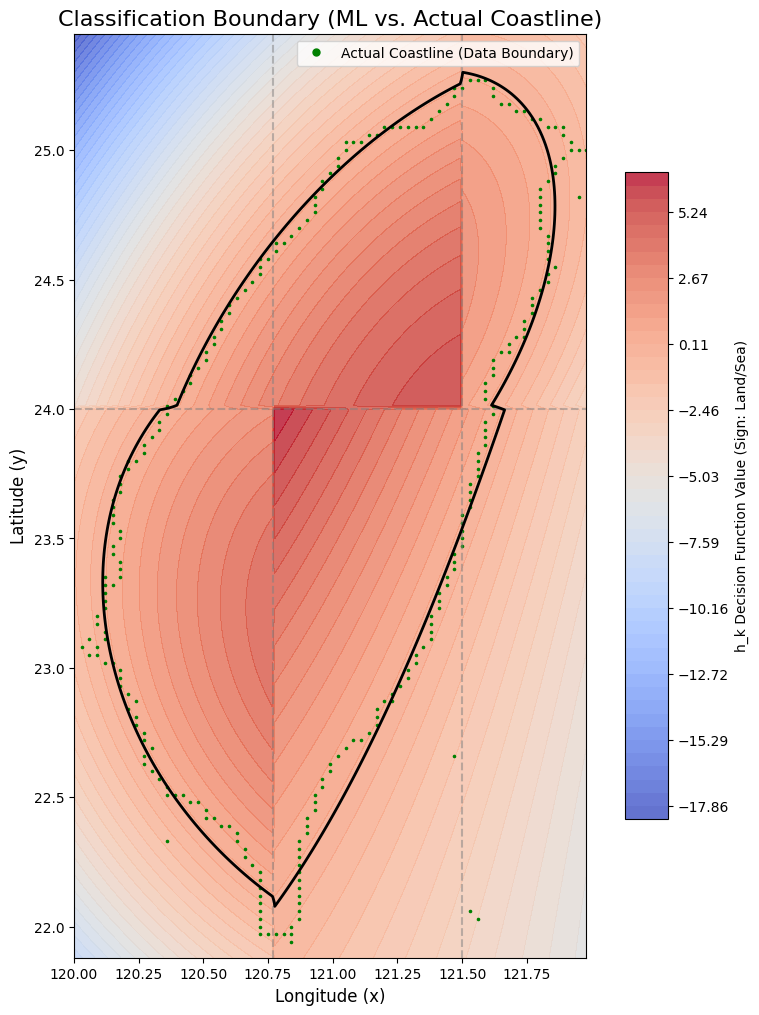

In [101]:
# ======================================================================
# 7B. PLOTTING COMPARING TO THE ACTUAL COASTLINE
# ======================================================================

# --- 7B. 2D Contour Plot of the Classification Boundary (h_k) - MODIFIED FOR REAL COASTLINE ---

# ... (Code for generating LON_PLOT_H, LAT_PLOT_H, H_PLOT remains unchanged) ...

# --- Extracting the Actual Coastline Data ---
print("\n--- Plotting Actual Coastline ---")

# (1) Find the indices of the valid data points in the original grid
valid_data_mask = (grid != INVALID_VAL)

# (2) Identify points *on the boundary* of the land mass
# A point is on the boundary if it is 'land' (valid_data_mask) 
# AND at least one of its immediate neighbors (N, S, E, W) is 'sea' (invalid).
boundary_points = []
rows, cols = grid.shape

for r in range(rows):
    for c in range(cols):
        if valid_data_mask[r, c]: # If current point is Land
            is_boundary = False
            # Check 4 neighbors (N, S, E, W)
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    if not valid_data_mask[nr, nc]: # Neighbor is Sea
                        is_boundary = True
                        break
            
            if is_boundary:
                # Use the center coordinates of the grid cell
                lon = LON_GRID[r, c]
                lat = LAT_GRID[r, c]
                boundary_points.append((lon, lat))

boundary_points = np.array(boundary_points)
if boundary_points.size == 0:
    print("Warning: Could not extract actual coastline boundary points.")


# --- Plotting Setup ---
fig, ax = plt.subplots(figsize=(10, 12))

# 1. Plot the filled contour (background classification)
contour_fill = ax.contourf(LON_PLOT_H, LAT_PLOT_H, H_PLOT,
                           levels=np.linspace(np.nanmin(H_PLOT), np.nanmax(H_PLOT), 50),
                           cmap='coolwarm', alpha=0.8)

# 2. Plot the PREDICTED boundary (ML Model's guess) in a solid black line
contour_line_predicted = ax.contour(LON_PLOT_H, LAT_PLOT_H, H_PLOT,
                                    levels=[0], colors='k', linewidths=2, linestyles='solid',
                                    label='Predicted Boundary (h_k=0)')

# 3. Plot the ACTUAL coastline (data boundary) in a dotted line
if boundary_points.size > 0:
    ax.scatter(boundary_points[:, 0], boundary_points[:, 1], 
               s=10, 
               color='green', 
               marker='.', 
               label='Actual Coastline (Data Boundary)')
    # Note: Using scatter for the individual grid points is generally clearer than trying to connect them with a continuous line plot.


# 4. Add Labels and Formatting
ax.set_title('Classification Boundary (ML vs. Actual Coastline)', fontsize=16)
ax.set_xlabel('Longitude (x)', fontsize=12)
ax.set_ylabel('Latitude (y)', fontsize=12)
ax.set_xlim(START_LON, END_LON)
ax.set_ylim(START_LAT, END_LAT)
ax.set_aspect('equal')

# Add region partition lines for reference
ax.axvline(LON_SPLIT_1, color='gray', linestyle='--', alpha=0.5)
ax.axvline(LON_SPLIT_2, color='gray', linestyle='--', alpha=0.5)
ax.axhline(LAT_SPLIT, color='gray', linestyle='--', alpha=0.5)

plt.colorbar(contour_fill, ax=ax, shrink=0.7, aspect=15,
             label='h_k Decision Function Value (Sign: Land/Sea)')

# Add a legend for clarity
ax.legend(handles=[
    contour_line_predicted.collections[0],
    plt.Line2D([0], [0], marker='.', color='green', linestyle='', markersize=10, label='Actual Coastline (Data Boundary)')
], loc='upper right')

plt.show()


--- Generating 2D Contour Plot for Logistic Regression Boundary ---


C:\Users\benny\AppData\Local\Temp\ipykernel_18352\173015827.py:82: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_line_lr.collections[0],
C:\Users\benny\AppData\Local\Temp\ipykernel_18352\173015827.py:81: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles=[


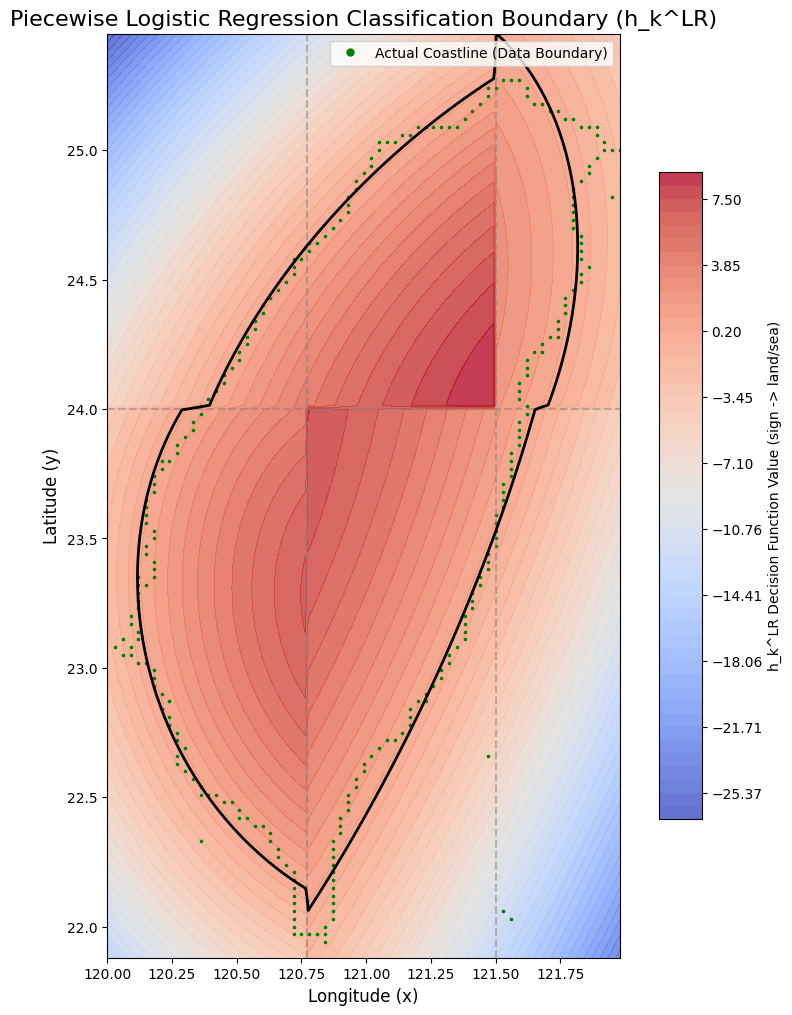

In [102]:
# ======================================================================
# 7C. 2D Contour Plot of the Piecewise Logistic Regression Boundary (h_k^LR)
# ======================================================================

print("\n--- Generating 2D Contour Plot for Logistic Regression Boundary ---")

# Re-use dense meshgrid for plotting (from Section 7B or similar)
lon_space_h = np.linspace(START_LON, END_LON, 200)
lat_space_h = np.linspace(START_LAT, END_LAT, 200)
LON_PLOT_H_LR, LAT_PLOT_H_LR = np.meshgrid(lon_space_h, lat_space_h)

X_plot_h_lr = np.column_stack([LON_PLOT_H_LR.ravel(), LAT_PLOT_H_LR.ravel()])
Z_plot_clf_h_lr = get_quad_features_clf(X_plot_h_lr) # Centered quadratic features

H_PRED_PLOT_LR = np.zeros(X_plot_h_lr.shape[0])

for i in range(len(X_plot_h_lr)):
    lon_val, lat_val = X_plot_h_lr[i]
    
    # Determine Region k (uses RAW coordinates)
    if lat_val > LAT_SPLIT: k = 1 if lon_val < LON_SPLIT_1 else 2
    else: k = 3 if lon_val < LON_SPLIT_2 else 4
        
    model_lr = h_lr_models.get(k)
    Z_i_lr = Z_plot_clf_h_lr[i].reshape(1, -1)

    if isinstance(model_lr, dict): 
        # For single-class regions, assign a high positive/negative value
        H_PRED_PLOT_LR[i] = 10.0 if model_lr['dominant_class'] == 1 else -10.0
    elif model_lr is not None:
        # LogisticRegression has a decision_function that works similarly to SVC for boundary plotting
        # It outputs values where the sign indicates the class.
        H_PRED_PLOT_LR[i] = model_lr.decision_function(Z_i_lr)[0]
    else: 
        H_PRED_PLOT_LR[i] = -10.0 # Default to 'sea' decision value if no model

H_PLOT_LR = H_PRED_PLOT_LR.reshape(LON_PLOT_H_LR.shape)

fig, ax = plt.subplots(figsize=(10, 12))

# 1. Plot the filled contour (color map showing positive/negative regions)
contour_fill_lr = ax.contourf(LON_PLOT_H_LR, LAT_PLOT_H_LR, H_PLOT_LR, 
                              levels=np.linspace(np.nanmin(H_PLOT_LR), np.nanmax(H_PLOT_LR), 50),
                              cmap='coolwarm', alpha=0.8)

# 2. Plot the zero contour line (THE BOUNDARY) in a solid black line
contour_line_lr = ax.contour(LON_PLOT_H_LR, LAT_PLOT_H_LR, H_PLOT_LR, 
                             levels=[0], colors='k', linewidths=2, linestyles='solid')

# 3. (Optional) Plot the ACTUAL coastline (data boundary) in green dotted points for comparison
# This assumes 'boundary_points' from the previous coastline extraction is still available.
# If not, you'll need to re-run the "Extracting the Actual Coastline Data" part from the previous response.
if 'boundary_points' in locals() and boundary_points.size > 0:
    ax.scatter(boundary_points[:, 0], boundary_points[:, 1],
               s=10,
               color='green',
               marker='.',
               label='Actual Coastline (Data Boundary)')
else:
    print("Note: 'boundary_points' not found. Actual coastline not plotted.")


# 4. Add Labels and Formatting
ax.set_title('Piecewise Logistic Regression Classification Boundary (h_k^LR)', fontsize=16)
ax.set_xlabel('Longitude (x)', fontsize=12)
ax.set_ylabel('Latitude (y)', fontsize=12)
ax.set_xlim(START_LON, END_LON)
ax.set_ylim(START_LAT, END_LAT)
ax.set_aspect('equal')

# Add region partition lines for reference
ax.axvline(LON_SPLIT_1, color='gray', linestyle='--', alpha=0.5, label='Partition Line 1')
ax.axvline(LON_SPLIT_2, color='gray', linestyle='--', alpha=0.5)
ax.axhline(LAT_SPLIT, color='gray', linestyle='--', alpha=0.5)

plt.colorbar(contour_fill_lr, ax=ax, shrink=0.7, aspect=15,
             label='h_k^LR Decision Function Value (sign -> land/sea)')

# Add a legend
if 'boundary_points' in locals() and boundary_points.size > 0:
    ax.legend(handles=[
        contour_line_lr.collections[0],
        plt.Line2D([0], [0], marker='.', color='green', linestyle='', markersize=10, label='Actual Coastline (Data Boundary)')
    ], loc='upper right')
else:
    ax.legend(handles=[contour_line_lr.collections[0]], loc='upper right')

plt.show()

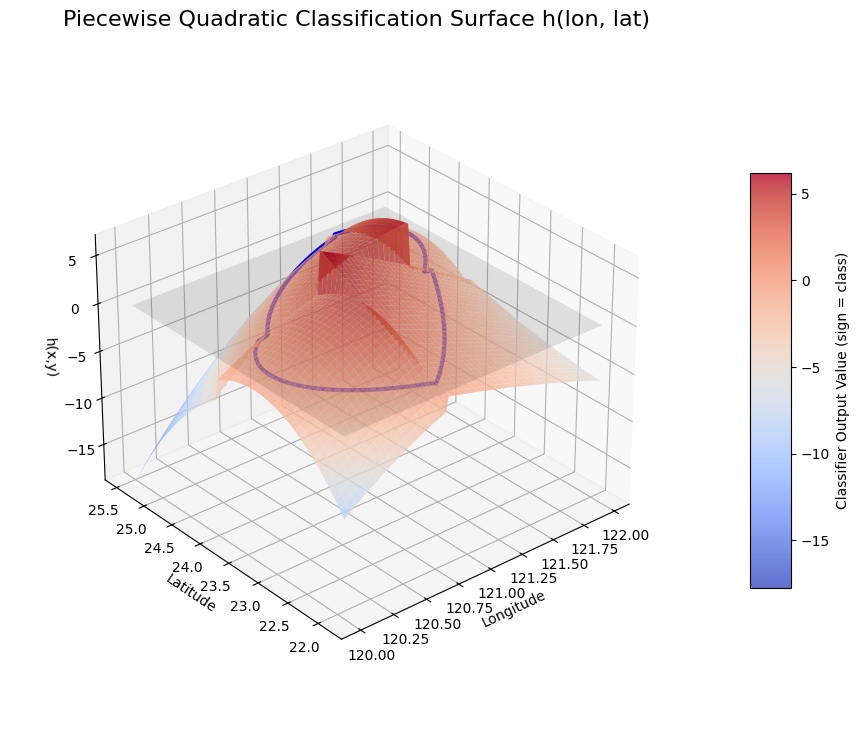

In [ ]:
# ======================================================================
# 7D. 3D Plot of the Piecewise Quadratic Classification Surface (h_k)
# ======================================================================

lon_space = np.linspace(START_LON, END_LON, 100)
lat_space = np.linspace(START_LAT, END_LAT, 100)
LON3D, LAT3D = np.meshgrid(lon_space, lat_space)

X_plot3d = np.column_stack([LON3D.ravel(), LAT3D.ravel()])
Z_plot3d = get_quad_features_clf(X_plot3d)  # quadratic features for classifiers

H_pred_3d = np.zeros(X_plot3d.shape[0])

# Evaluate piecewise classifiers
for i in range(len(X_plot3d)):
    lon_val, lat_val = X_plot3d[i]
    if lat_val > LAT_SPLIT:
        k = 1 if lon_val < LON_SPLIT_1 else 2
    else:
        k = 3 if lon_val < LON_SPLIT_2 else 4

    model_h = h_models.get(k)
    Z_i = Z_plot3d[i].reshape(1, -1)

    if isinstance(model_h, dict):
        H_pred_3d[i] = model_h['dominant_class']
    elif model_h is not None:
        H_pred_3d[i] = model_h.decision_function(Z_i)[0]
    else:
        H_pred_3d[i] = -1.0

H_pred_3d = H_pred_3d.reshape(LON3D.shape)

# --- Plotting ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(LON3D, LAT3D, H_pred_3d,
                       cmap='coolwarm',
                       edgecolor='none',
                       alpha=0.8)

ax.contour3D(LON3D, LAT3D, H_pred_3d,
             levels=[0],           # Only plot the contour at z=0
             colors='b',           # Distinct color (Red) for high visibility
             linewidths=3,
             linestyles='solid')

# Decision boundary plane (z=0)
ax.plot_surface(LON3D, LAT3D, np.zeros_like(H_pred_3d),
                color='k', alpha=0.1)

# 1. Set the Z-axis limits
# ax.set_zlim(-4, 6) # <--- ADDED LINE

ax.set_title("Piecewise Quadratic Classification Surface h(lon, lat)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("h(x,y)") # <--- MODIFIED LINE: Added labelpad=10
ax.view_init(elev=30, azim=230)
ax.set_box_aspect(None, zoom=0.85)

plt.colorbar(surf, ax=ax, shrink=0.6, aspect=10,
             label="Classifier Output Value (sign = class)")
plt.show()


In [104]:
# ======================================================================
# 8. GLOBAL CUBIC REGRESSION (g_global) - TRAIN AND EVALUATE
# ======================================================================

print("\n--- 8. Training Global Cubic Regression Model (g_global) ---")

# 8A. Prepare Data
Z_cubic_train = get_cubic_features(X_reg_train) # Centered Cubic Features
Z_cubic_test = get_cubic_features(X_reg_test)   # Centered Cubic Features

# 8B. Train Model
g_global_model = LinearRegression(fit_intercept=False)
g_global_model.fit(Z_cubic_train, y_reg_train)

# 8C. Evaluate Model
y_reg_test_pred_global = g_global_model.predict(Z_cubic_test)
global_test_mse = mean_squared_error(y_reg_test, y_reg_test_pred_global)
global_test_rmse = np.sqrt(global_test_mse)

print(f"Global Cubic Regression trained with {len(X_reg_train)} points.")
print(f"Global Test RMSE for g_global: {global_test_rmse:.4f} °C")

print("\n--- Global Cubic Regression Coefficients ---")
# Coefficients order: [1, x', y', x'^2, x'y', y'^2, x'^3, x'^2y', x'y'^2, y'^3]
coeffs = g_global_model.coef_
coeff_names = ['f (Intercept)', 'd (x\')', 'e (y\')', 'a (x\'²)', 'c (x\'y\')', 'b (y\'²)', 'x\'³', 'x\'²y\'', 'x\'y\'²', 'y\'³']
for name, coeff in zip(coeff_names, coeffs):
    print(f"  {name:<15}: {coeff:.6f}")


--- 8. Training Global Cubic Regression Model (g_global) ---
Global Cubic Regression trained with 2796 points.
Global Test RMSE for g_global: 4.4450 °C

--- Global Cubic Regression Coefficients ---
  f (Intercept)  : 14.060621
  d (x')         : -6.893173
  e (y')         : 0.966695
  a (x'²)        : 37.411337
  c (x'y')       : -19.805539
  b (y'²)        : 8.764222
  x'³            : 34.963902
  x'²y'          : -27.916365
  x'y'²          : 5.014845
  y'³            : -0.559400



--- 9. Plotting Global Cubic Surface ---


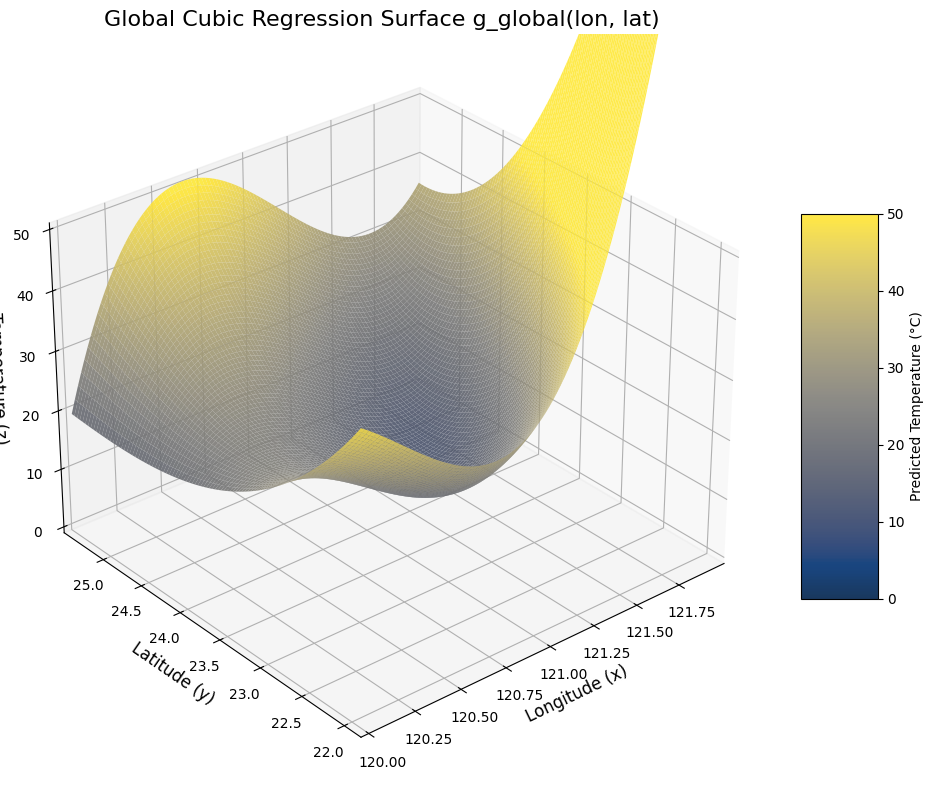

In [105]:
# ======================================================================
# 9. PLOTTING GLOBAL CUBIC SURFACE (g_global)
# ======================================================================

print("\n--- 9. Plotting Global Cubic Surface ---")

# Re-use dense meshgrid for plotting (from previous Section 7)
# LON_PLOT, LAT_PLOT, X_plot (raw coordinates)
lon_space = np.linspace(START_LON, END_LON, 100)
lat_space = np.linspace(START_LAT, END_LAT, 100)
LON_PLOT, LAT_PLOT = np.meshgrid(lon_space, lat_space)
X_plot = np.column_stack([LON_PLOT.ravel(), LAT_PLOT.ravel()])

# Generate cubic features for the plot grid
Z_plot_cubic = get_cubic_features(X_plot)
Z_PRED_PLOT_GLOBAL = g_global_model.predict(Z_plot_cubic)
Z_PLOT_GLOBAL = Z_PRED_PLOT_GLOBAL.reshape(LON_PLOT.shape)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(LON_PLOT, LAT_PLOT, Z_PLOT_GLOBAL,
                       cmap='cividis',
                       edgecolor='none',
                       alpha=0.9,
                       rstride=1, cstride=1,
                       linewidth=0,
                       vmin=0, 
                       vmax=50)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Predicted Temperature (°C)')

ax.set_title('Global Cubic Regression Surface g_global(lon, lat)', fontsize=16)
ax.set_xlabel('Longitude (x)', fontsize=12)
ax.set_ylabel('Latitude (y)', fontsize=12)
ax.set_zlabel('Temperature (z)', fontsize=12)

# Adjust Z-axis limits for better visualization
ax.set_zlim(0, 50)
ax.set_xlim(START_LON, END_LON)
ax.set_ylim(START_LAT, END_LAT)

ax.view_init(elev=30, azim=230)
plt.show()


--- 10. Final Masked Hypothesis Grid (h_global) ---
Final global predicted grid shape: (120, 67)


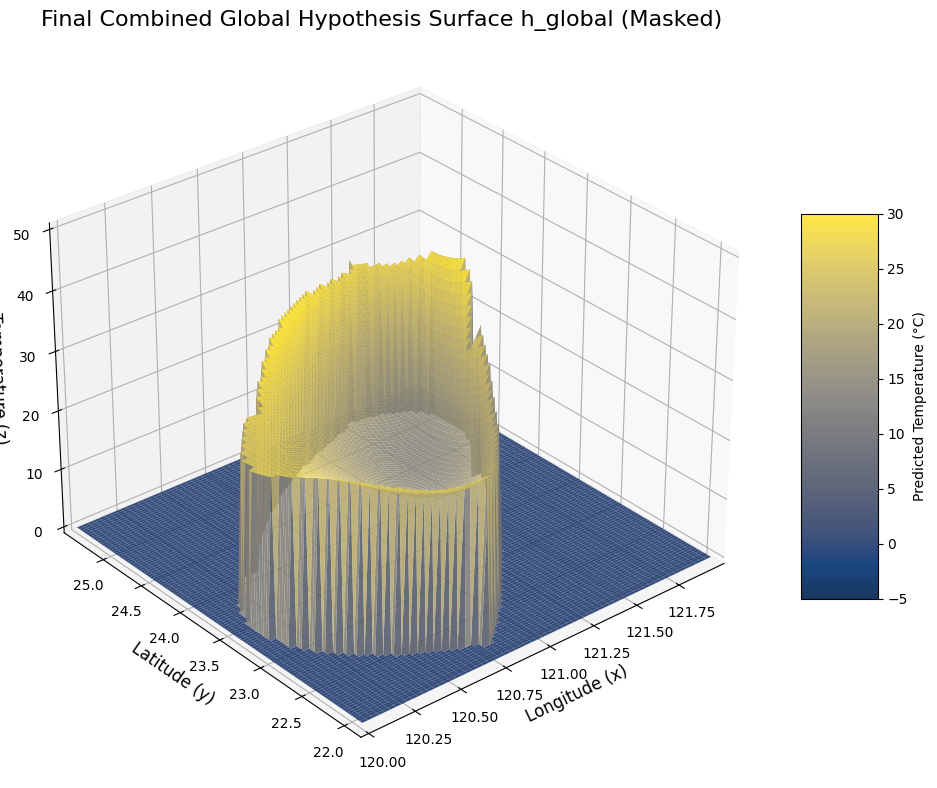

In [ ]:
# ======================================================================
# 10A. FINAL MASKED HYPOTHESIS (h_global = g_global * mask)
# ======================================================================

print("\n--- 10. Final Masked Hypothesis Grid (h_global) ---")

# We apply the existing, trained piecewise classification mask (h_k)
# to the predictions of the new global cubic model (g_global).

Z_clf_cubic = get_cubic_features(X_clf) # Cubic features for full grid

FULL_GRID_SIZE = len(X_clf)
g_pred_full_global = g_global_model.predict(Z_clf_cubic)

# h_mask_full_neg1_1 was calculated in Section 6, let's re-calculate it for completeness
# (This step assumes h_models and other classification results are still in memory)
# You may need to execute Section 6 again if running in a fresh environment
Z_clf_clf = get_quad_features_clf(X_clf)
h_mask_full_neg1_1_global = predict_h_quadratic_neg1_1(X_clf, Z_clf_clf, h_models, LON_SPLIT_1, LON_SPLIT_2, LAT_SPLIT)

# Convert the -1/1 prediction to the 0/1 mask
final_mask_0_1_global = np.where(h_mask_full_neg1_1_global == 1, 1, 0)

# Final Hypothesis: h_global = g_global * (0/1 mask)
h_pred_flat_global = g_pred_full_global * final_mask_0_1_global
predicted_grid_global = h_pred_flat_global.reshape(GRID_LAT_SIZE, GRID_LON_SIZE)

print(f"Final global predicted grid shape: {predicted_grid_global.shape}")

# --- 10A. 3D Plot of the Final Combined Global Hypothesis (h_global) ---

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(LON_GRID, LAT_GRID, predicted_grid_global,
                       cmap='cividis',
                       edgecolor='none',
                       alpha=0.9,
                       rstride=1, cstride=1,
                       linewidth=0,
                       vmin=-5, 
                       vmax=30)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Predicted Temperature (°C)')

ax.set_title('Final Combined Global Hypothesis Surface h_global (Masked)', fontsize=16)
ax.set_xlabel('Longitude (x)', fontsize=12)
ax.set_ylabel('Latitude (y)', fontsize=12)
ax.set_zlabel('Temperature (z)', fontsize=12)

ax.set_zlim(0, 50)
ax.set_xlim(START_LON, END_LON)
ax.set_ylim(START_LAT, END_LAT)

ax.view_init(elev=30, azim=230)
plt.show()

Using prediction variable: ...


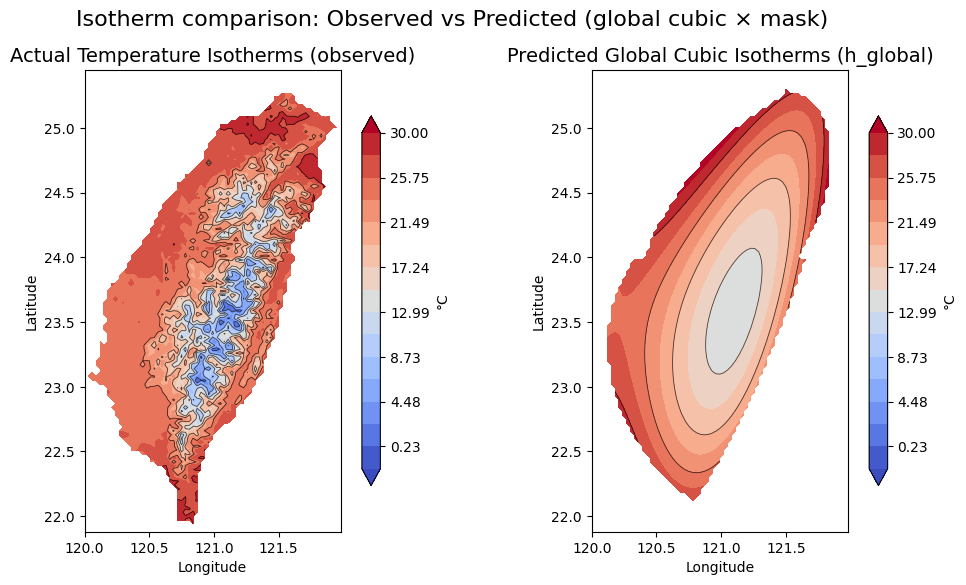


Points compared: 3357 / 8040
Mean Absolute Error (MAE): 3.0688 °C
Root Mean Squared Error (RMSE): 4.0418 °C


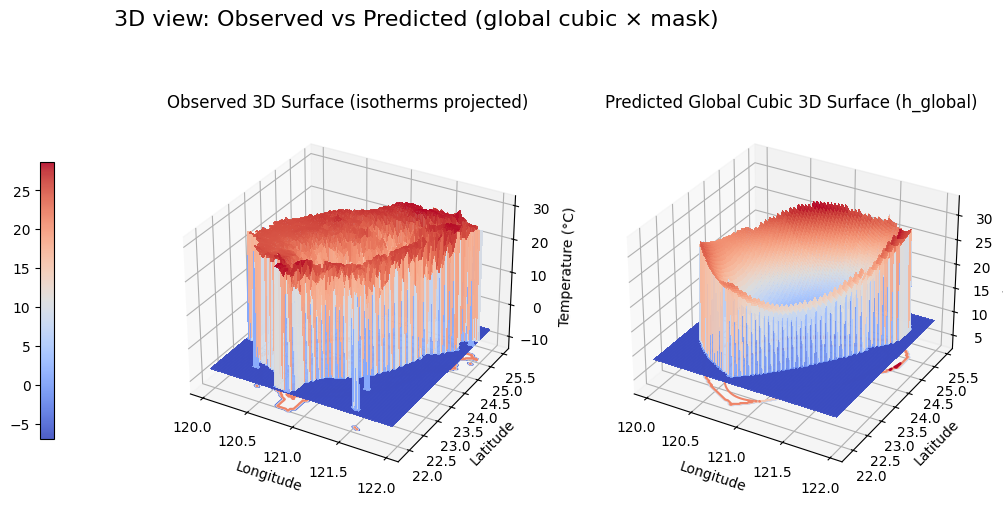

In [120]:
# ======================================================================
# 10B. ISOTHERM COMPARISON: ACTUAL (observed) vs PREDICTED (Robust Fix)
# ======================================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- VARIABLE FALLBACK CHECK ---
# Check for global hypothesis variables (Section 10) first, fall back to piecewise (Section 6)
if 'predicted_grid_global' in globals():
    PRED_GRID = predicted_grid_global
    MASK_0_1 = final_mask_0_1_global.reshape(GRID_LAT_SIZE, GRID_LON_SIZE) if 'final_mask_0_1_global' in globals() else None
    PRED_TITLE = "Predicted Global Cubic Isotherms (h_global)"
    SUP_TITLE = "Isotherm comparison: Observed vs Predicted (global cubic × mask)"
elif 'predicted_grid' in globals():
    PRED_GRID = predicted_grid
    MASK_0_1 = final_mask_0_1.reshape(GRID_LAT_SIZE, GRID_LON_SIZE) if 'final_mask_0_1' in globals() else None
    PRED_TITLE = "Predicted Piecewise Quadratic Isotherms (h_k)"
    SUP_TITLE = "Isotherm comparison: Observed vs Predicted (piecewise quadratic × mask)"
else:
    raise NameError("Neither 'predicted_grid_global' (Sec 10) nor 'predicted_grid' (Sec 6) is defined. Run the preceding sections first.")
    
print(f"Using prediction variable: {PRED_GRID.__name__ if hasattr(PRED_GRID, '__name__') else '...'}")


# 1) Build masked actual observation grid
obs_grid = np.where(grid == INVALID_VAL, np.nan, grid) 

# 2) Build displayed predicted grid:
if MASK_0_1 is not None:
    pred_display = np.where(MASK_0_1 == 1, PRED_GRID, np.nan)
else:
    pred_display = np.where(PRED_GRID == 0, np.nan, PRED_GRID)


# 3) Compute common plotting range (using observed valid range)
vmin = np.nanmin(obs_grid) if np.isfinite(obs_grid).any() else 5.0
vmax = np.nanmax(obs_grid) if np.isfinite(obs_grid).any() else 30.0
levels = np.linspace(vmin, vmax, 16)


# 4) 2D ISOTHERM COMPARISON (filled contours + contour lines)
# FIX APPLIED HERE: Reduced width (16 -> 12) and removed constrained_layout
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

# --- Observed Plot ---
c0 = axes[0].contourf(LON_GRID, LAT_GRID, obs_grid, levels=levels, cmap="coolwarm", extend='both')
axes[0].contour(LON_GRID, LAT_GRID, obs_grid, levels=levels[::2], colors='k', linewidths=0.6, alpha=0.7)
axes[0].set_title("Actual Temperature Isotherms (observed)", fontsize=14)
axes[0].set_xlabel("Longitude"); axes[0].set_ylabel("Latitude")
fig.colorbar(c0, ax=axes[0], shrink=0.8, label="°C")
axes[0].set_aspect('equal', adjustable='box')

# --- Predicted Plot ---
c1 = axes[1].contourf(LON_GRID, LAT_GRID, pred_display, levels=levels, cmap="coolwarm", extend='both')
axes[1].contour(LON_GRID, LAT_GRID, pred_display, levels=levels[::2], colors='k', linewidths=0.6, alpha=0.7)
axes[1].set_title(PRED_TITLE, fontsize=14)
axes[1].set_xlabel("Longitude"); axes[1].set_ylabel("Latitude")
fig.colorbar(c1, ax=axes[1], shrink=0.8, label="°C")
axes[1].set_aspect('equal', adjustable='box')

plt.suptitle(SUP_TITLE, fontsize=16)
plt.show()

# 5) ERROR METRICS (compute over positions where both obs and pred are present)
mask_valid = ~np.isnan(obs_grid) & ~np.isnan(pred_display)
if mask_valid.any():
    diff = pred_display[mask_valid] - obs_grid[mask_valid]
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    print(f"\nPoints compared: {mask_valid.sum()} / {obs_grid.size}")
    print(f"Mean Absolute Error (MAE): {mae:.4f} °C")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f} °C")
else:
    print("\nNo overlapping valid points between observed and predicted to compute errors.")

# 6) 3D SURFACES + ISOTHERM LINES (for geometry)
#    Replace NaNs by a conservative fill for plotting surface (can't plot NaN on surface)
fill_obs = np.nanmin(obs_grid) - 5.0 if np.isfinite(obs_grid).any() else 0.0
fill_pred_val = np.nanmin(pred_display[np.isfinite(pred_display)]) if np.isfinite(pred_display).any() else fill_obs
fill_pred = fill_pred_val - 5.0
# Fallback for fill_pred if all predicted are nan
if not np.isfinite(fill_pred): fill_pred = fill_obs

obs_surface = np.nan_to_num(obs_grid, nan=fill_obs)
pred_surface = np.nan_to_num(pred_display, nan=fill_pred)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(LON_GRID, LAT_GRID, obs_surface, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.9)
ax1.contour(LON_GRID, LAT_GRID, obs_surface, zdir='z', offset=np.min(obs_surface)-6, levels=levels[::3], cmap='coolwarm')
ax1.set_title("Observed 3D Surface (isotherms projected)", fontsize=12)
ax1.set_xlabel("Longitude"); ax1.set_ylabel("Latitude"); ax1.set_zlabel("Temperature (°C)")
ax1.set_zlim(np.min(obs_surface)-6, np.max(obs_surface)+2)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(LON_GRID, LAT_GRID, pred_surface, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.9)
ax2.contour(LON_GRID, LAT_GRID, pred_surface, zdir='z', offset=np.min(pred_surface)-6, levels=levels[::3], cmap='coolwarm')
ax2.set_title(PRED_TITLE.replace("Isotherms", "3D Surface"), fontsize=12)
ax2.set_xlabel("Longitude"); ax2.set_ylabel("Latitude"); ax2.set_zlabel("g(x,y) (°C)")
ax2.set_zlim(np.min(pred_surface)-6, np.max(pred_surface)+2)

fig.colorbar(surf1, ax=[ax1, ax2], shrink=0.6, aspect=20, location='left')
plt.suptitle(SUP_TITLE.replace("Isotherm comparison", "3D view"), fontsize=16)
plt.show()